# House Prices Prediction using Blending Ensemble

Author: [Enrique Companioni]([https://github.com/EnriqManComp)

---

* Data

The dataset contain many 


# Import Libraries

In [70]:
!pip install missingno
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.9 MB/s eta 0:00:00:00:0100:01


In [1]:
import numpy as np 
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

# Statistical library
from scipy.stats import skew 

# Missing value visualization
import missingno as msno

# Seaborn configuration style
sns.set_style("darkgrid")

# Import data

## Training data

In [2]:
# Read data
train_dataset = pd.read_csv("/workspaces/kaggle-competitions/house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques/train.csv")
# Dataset dimensions
print(f"Shape of the dataset: {train_dataset.shape}")
# Show data sample
train_dataset.head()

Shape of the dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Exploration Data Analysis (EDA)

### Check duplicated Ids

In [3]:
print("There are {0} duplicated Ids".format(train_dataset['Id'].duplicated().sum()))
# Drop Id column
train_dataset = train_dataset.drop(['Id'], axis=1)

There are 0 duplicated Ids


### Check dataset dtype

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Exploring Sale Price column

<Axes: xlabel='SalePrice', ylabel='Density'>

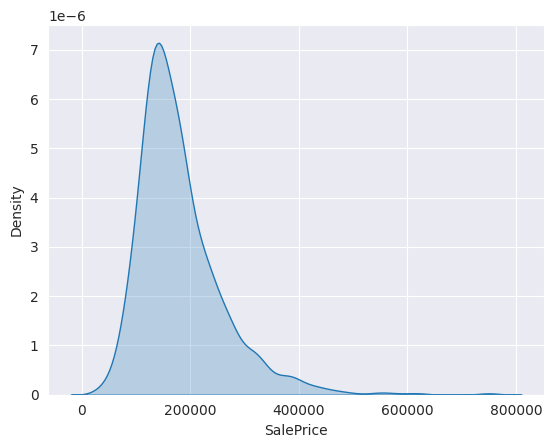

In [5]:
# Distribution of the sale price column
sns.kdeplot(
    data=train_dataset,
    x="SalePrice",    
    fill=True    
)

<p style="font-size:16px;">
The Sale Price column is right skewed. The proper form to treat this type of variables with linear models is convert the data to normally distributed data. When the data is 
</p>

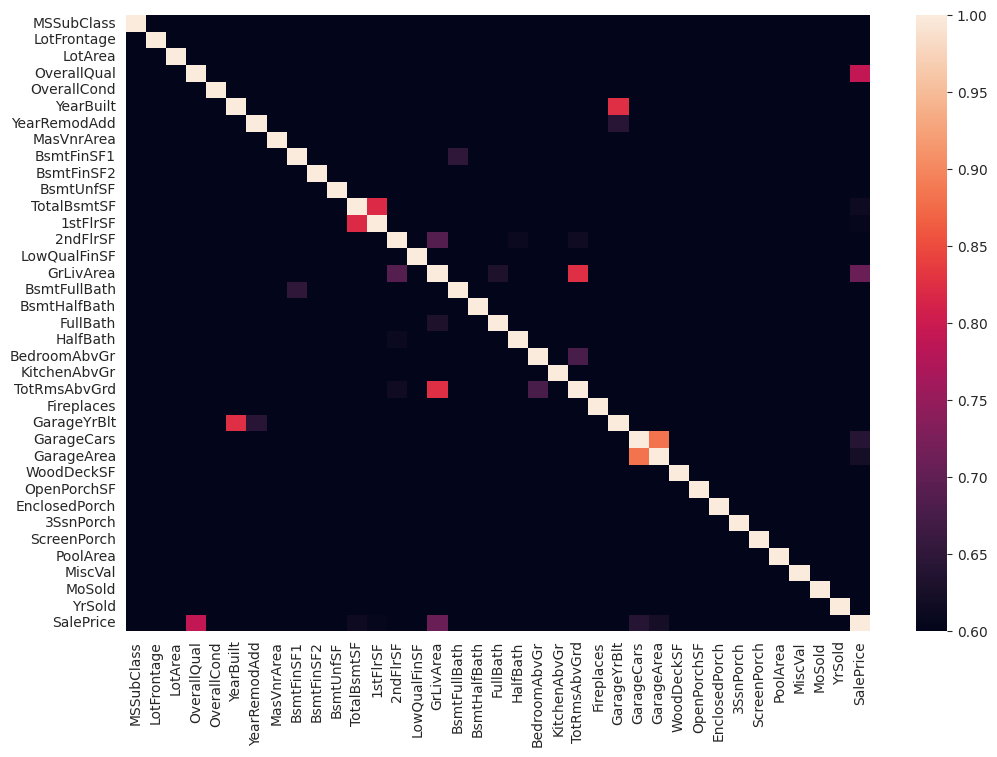

In [6]:
plt.subplots(figsize=(12,8))
sns.heatmap(data=train_dataset.corr(numeric_only=True), vmin=0.6)
plt.show()

<Axes: xlabel='GarageArea', ylabel='SalePrice'>

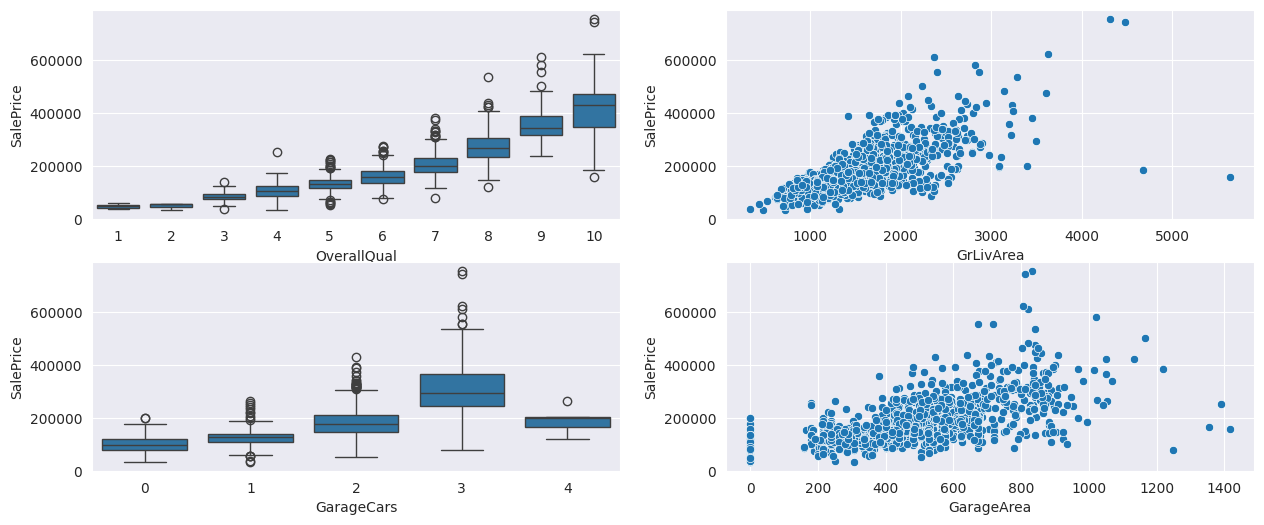

In [7]:
fig, axs = plt.subplots(2,2, figsize=(15, 6))
sns.boxplot(x='OverallQual', y="SalePrice", data=train_dataset, ax=axs[0,0])
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_dataset, ax=axs[0,1])
sns.boxplot(x='GarageCars', y="SalePrice", data=train_dataset, ax=axs[1,0])
sns.scatterplot(x='GarageArea', y="SalePrice", data=train_dataset, ax=axs[1,1])

In [8]:
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GrLivArea'] <= 4000), :]
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GarageArea'] <= 1200), :]
train_dataset = train_dataset.loc[(train_dataset['SalePrice'] <= 600_000) & (train_dataset['GarageCars'] <=4 ), :]
train_dataset.shape

(1450, 80)

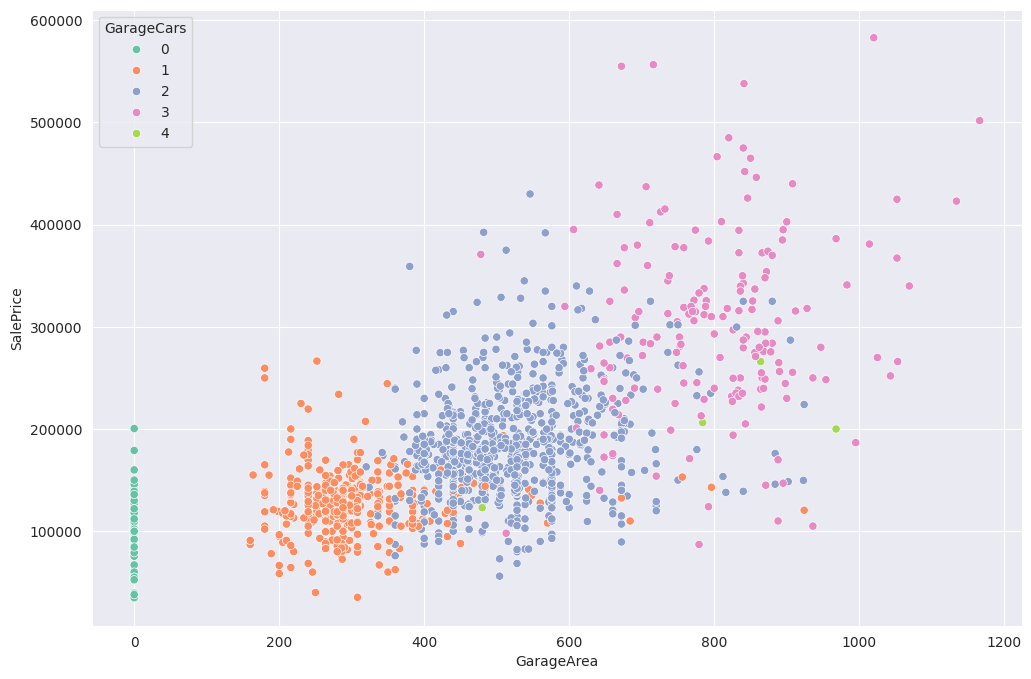

In [9]:
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=train_dataset, x='GarageArea', y='SalePrice', hue='GarageCars', palette="Set2")
plt.show()

In [10]:
train_dataset = train_dataset.loc[train_dataset['GarageCars'] < 4, :]
train_dataset.shape

(1446, 80)

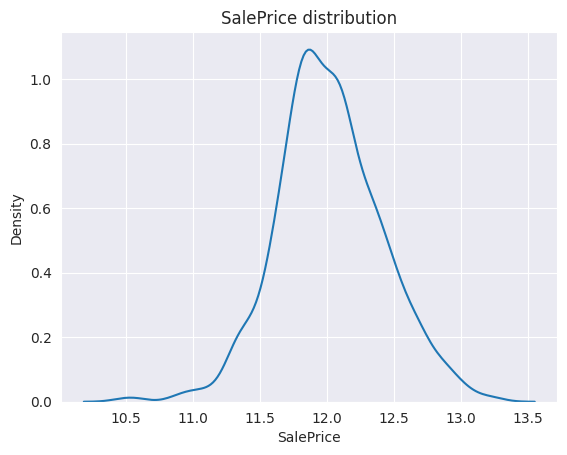

In [11]:
train_dataset['SalePrice'] = np.log1p(train_dataset['SalePrice'])

# New distribution 
sns.kdeplot(train_dataset['SalePrice'])
plt.title('SalePrice distribution')
plt.show()

## Missing values

<Axes: >

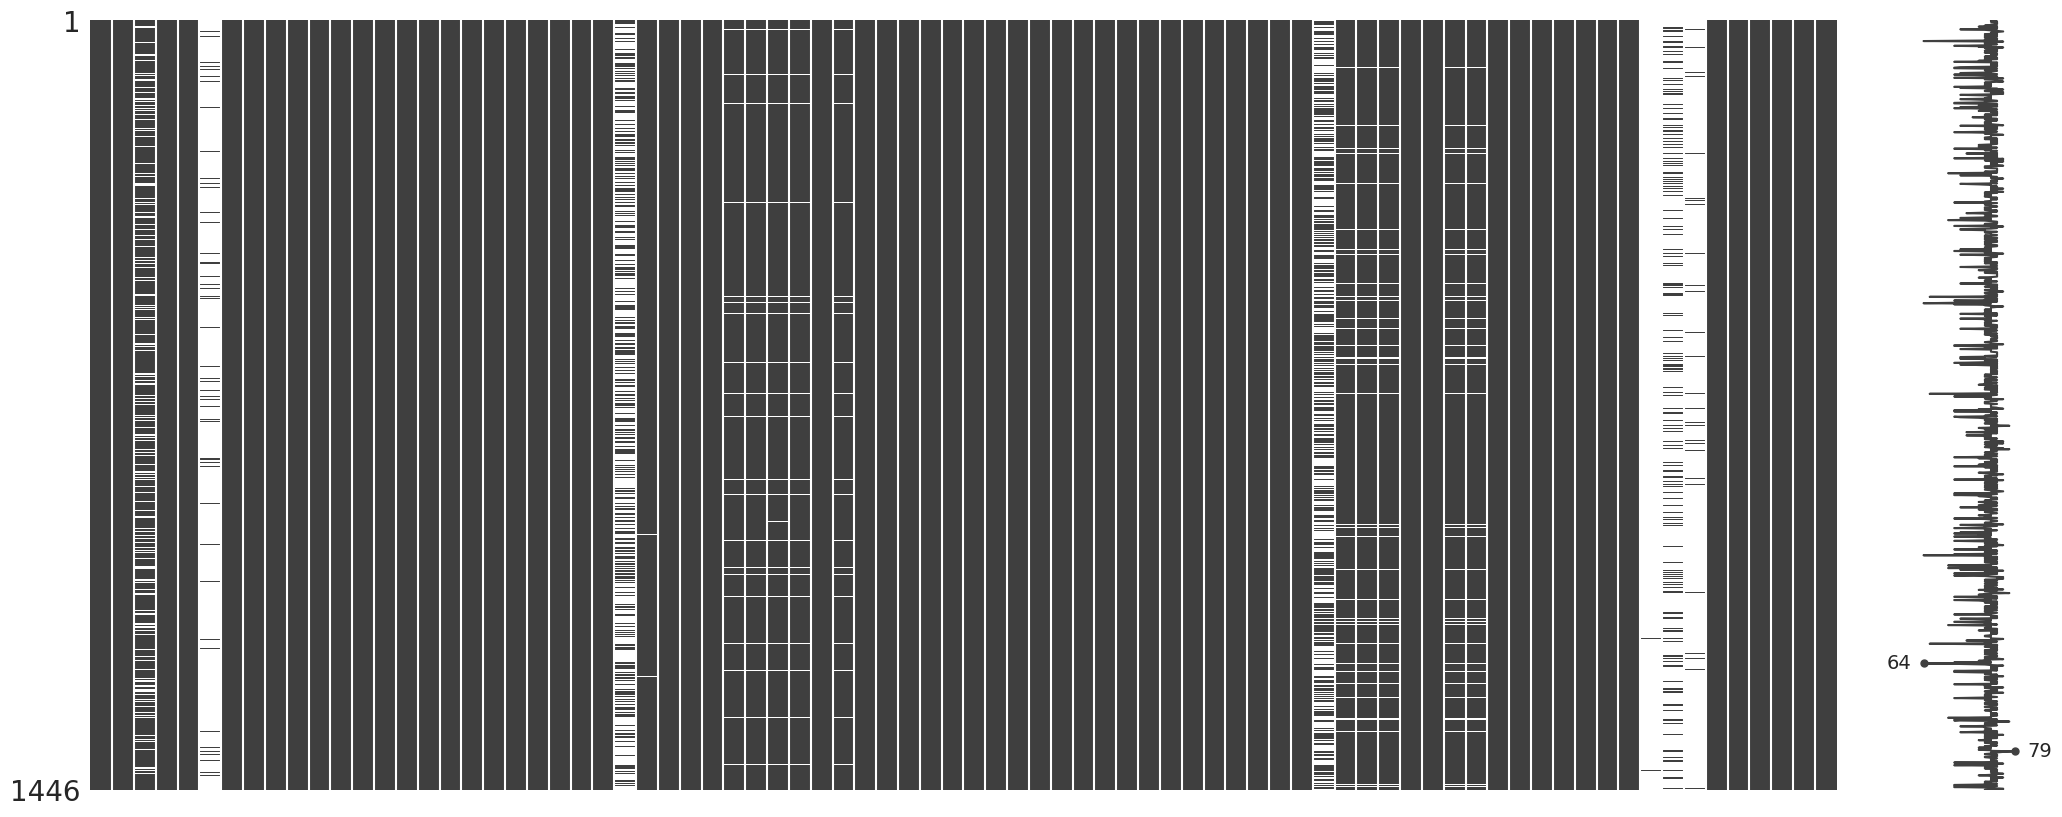

In [12]:
# Visualize missing values
msno.matrix(train_dataset)

In [13]:
# Check the columns with missing values
print(train_dataset.columns[train_dataset.isna().sum() > 0])

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


Proportion of missing values in each column

In [14]:
def proportion_miss_values(column):
    miss_value_sum = train_dataset[column].isna().sum() 
    return pd.Series(miss_value_sum / train_dataset.shape[0], index=[column])

### Distribution of missing columns

/tmp/ipykernel_1290/132022358.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')


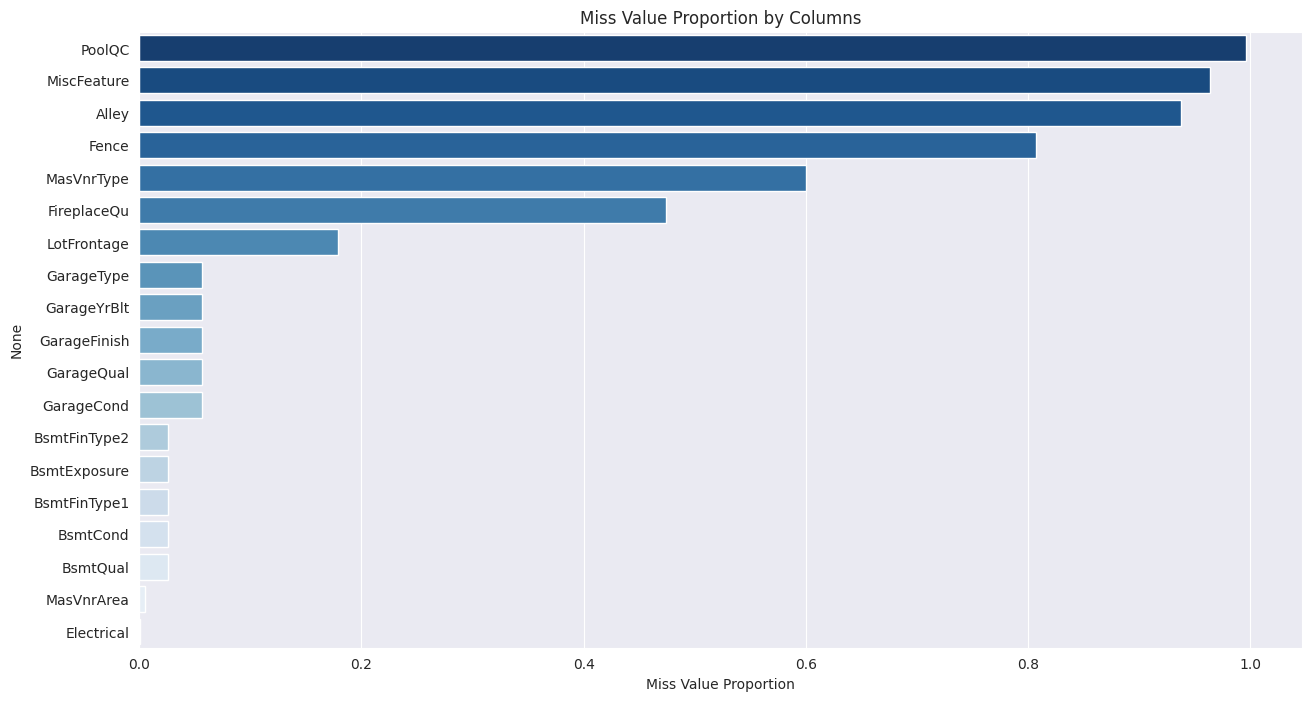

In [15]:
proportion_df = pd.DataFrame([])
missing_columns = train_dataset.columns[train_dataset.isna().sum() > 0]
for i, column in enumerate(missing_columns):
    new_proportion = proportion_miss_values(column)
    proportion_df = pd.concat([proportion_df, new_proportion], axis=0)     

proportion_df.columns = ['miss_value_proportion']
proportion_df = proportion_df.sort_values('miss_value_proportion', ascending=False)
fig = plt.figure(figsize=(15,8))
sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')
plt.xlabel("Miss Value Proportion")
plt.title("Miss Value Proportion by Columns")
plt.show()

/tmp/ipykernel_2120/109769577.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_dataset, x='MasVnrType', palette="Set2", ax=axs[0]).set_ylabel("Count of categories")


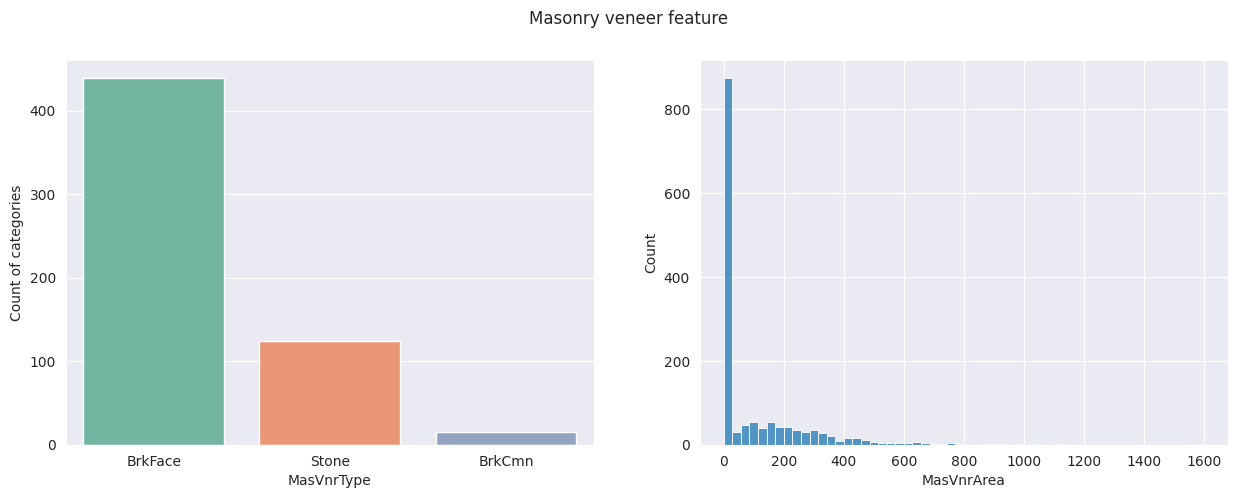

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data=train_dataset, x='MasVnrType', palette="Set2", ax=axs[0]).set_ylabel("Count of categories")
sns.histplot(train_dataset['MasVnrArea'], ax=axs[1])
plt.suptitle("Masonry veneer feature")
plt.show()

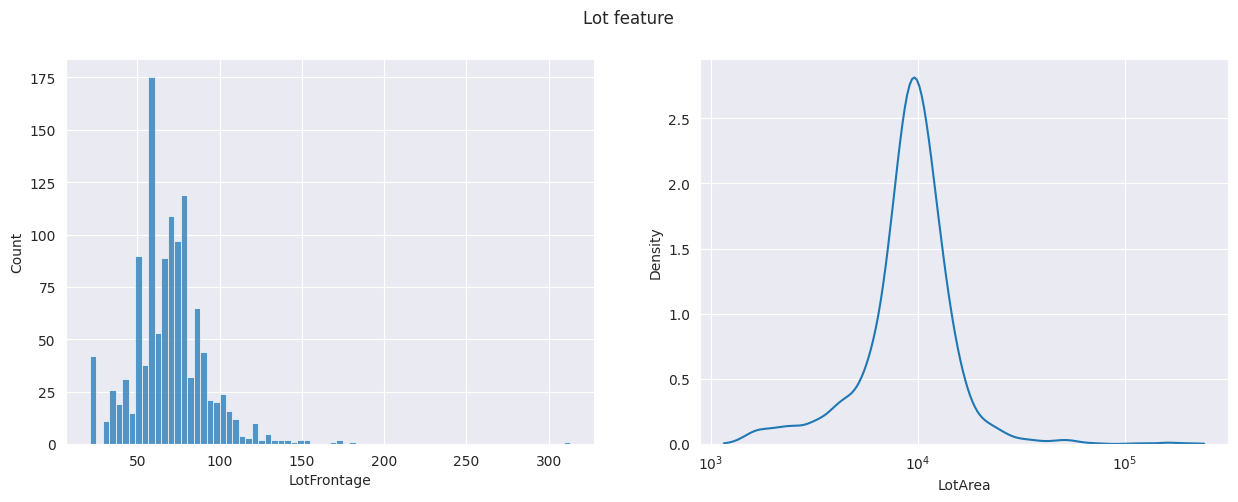

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train_dataset, x='LotFrontage', ax=axs[0])
sns.kdeplot(train_dataset['LotArea'], cut=1, log_scale=True, ax=axs[1])
plt.suptitle("Lot feature")
plt.show()

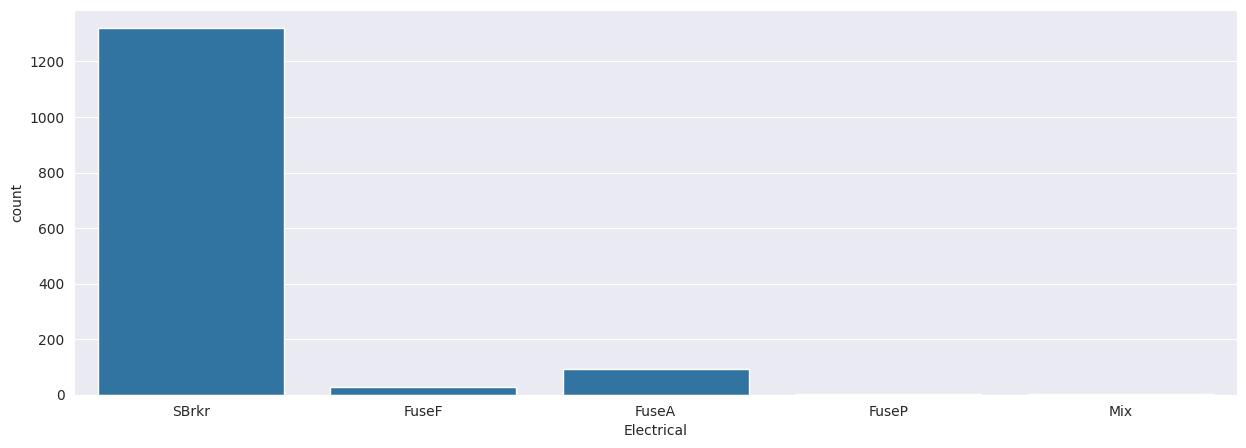

In [17]:
plt.subplots(figsize=(15,5))
sns.countplot(data=train_dataset, x='Electrical')
plt.show()

<p style="font-size:16px;">According to the dataset description, missing data appears in columns where a category of "No ..." or something similar exists. Also, when the categorical columns "GarageType" does not contain "Garage", or when the column "MasVnrType" contains "None", the values for "GarageYrBlt" and "MasVnrArea" are set to 0, rather than being considered as missing values.</p>

In [18]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": np.median(train_dataset[~train_dataset['LotFrontage'].isna()]['LotFrontage']),
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None",
    "Electrical": "SBrkr"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

### Handling missing categories

In [19]:
for column, fill_value in target_missing_columns.items():    
    train_dataset[column] = train_dataset[column].fillna(fill_value)  

### Handling missing values of dependent columns

In [20]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    train_dataset.loc[train_dataset[column] == value, dependent_column] = 0    

<Axes: >

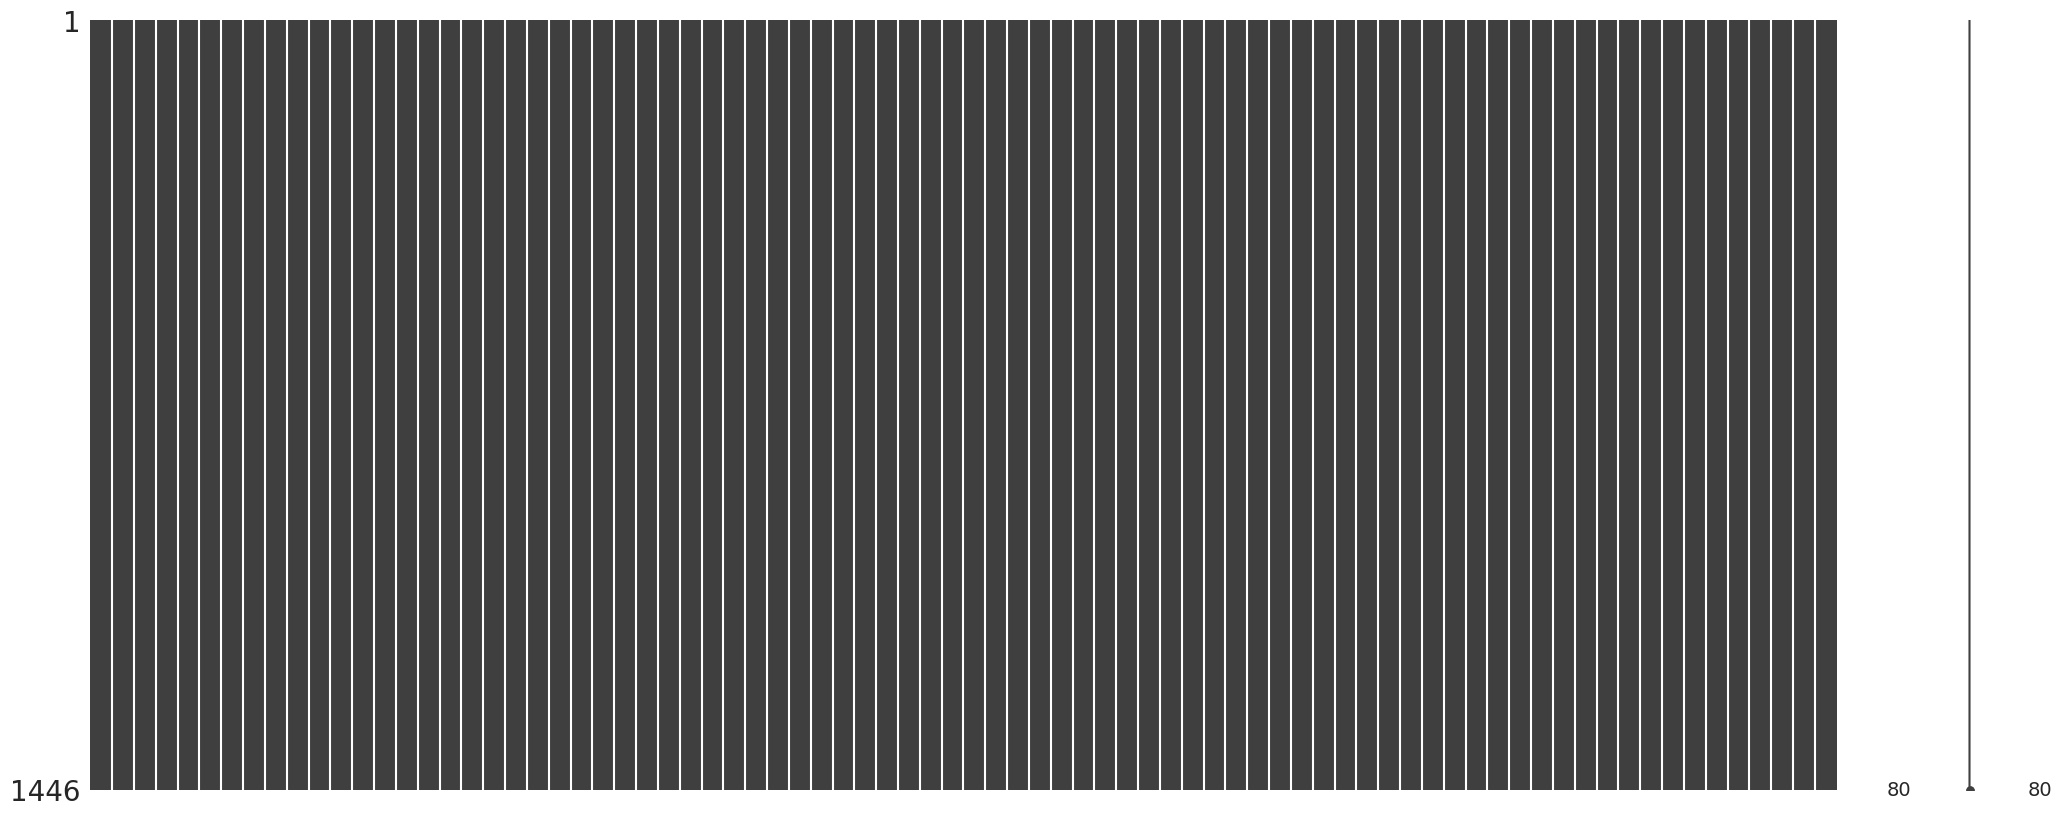

In [21]:
# Visualize missing values
msno.matrix(train_dataset)

## Correction of fields

Convert all the categorical columns to object type

In [22]:
categorical_columns = (
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", \
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", \
    "KitchenQual", "Functional", \
    "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", \
    "MiscFeature", "YrSold", "SaleType", "SaleCondition"    
)
auto_label_encoder = [
    "OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath", \
    "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", \
    "Fireplaces", "GarageCars", "MoSold"
]

In [23]:
train_dataset[list(auto_label_encoder)].dtypes

OverallQual     int64
OverallCond     int64
BsmtFullBath    int64
BsmtHalfBath    int64
FullBath        int64
HalfBath        int64
BedroomAbvGr    int64
KitchenAbvGr    int64
TotRmsAbvGrd    int64
Fireplaces      int64
GarageCars      int64
MoSold          int64
dtype: object

In [24]:
def change_dtype(dataset, column, type):
    """
        To change the type of the columns of the dataset
        Args:
            dataset (pandas DataFrame)
            column (string): Columns to change
            type (string): New type for the columns
    """
    return dataset[column].astype(type)

# Convert to the right type
for cat_column in categorical_columns:
    train_dataset[cat_column] = change_dtype(train_dataset, cat_column, "object")

In [25]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1446 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1446 non-null   object 
 1   MSZoning       1446 non-null   object 
 2   LotFrontage    1446 non-null   float64
 3   LotArea        1446 non-null   int64  
 4   Street         1446 non-null   object 
 5   Alley          1446 non-null   object 
 6   LotShape       1446 non-null   object 
 7   LandContour    1446 non-null   object 
 8   Utilities      1446 non-null   object 
 9   LotConfig      1446 non-null   object 
 10  LandSlope      1446 non-null   object 
 11  Neighborhood   1446 non-null   object 
 12  Condition1     1446 non-null   object 
 13  Condition2     1446 non-null   object 
 14  BldgType       1446 non-null   object 
 15  HouseStyle     1446 non-null   object 
 16  OverallQual    1446 non-null   int64  
 17  OverallCond    1446 non-null   int64  
 18  YearBuilt    

# Preprocessing Data

In [26]:
# Get the features and labels
X = train_dataset.iloc[:, :-1]
y = train_dataset.iloc[:, -1]

## Convert to Label Encoder

Label Encoder can be useful in categorical variables that give some notion of ordinal sort, ratings or categorical values represented as numbers

In [27]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

**Apply Label Encoder to the data**

In [28]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    X[column] = encoder.fit_transform(X[column].values)
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,5,RL,65.0,8450,Pave,No Alley,3,3,AllPub,Inside,...,0,0,3,4,None,0,2,2,WD,Normal
1,0,RL,80.0,9600,Pave,No Alley,3,3,AllPub,FR2,...,0,0,3,4,None,0,5,1,WD,Normal
2,5,RL,68.0,11250,Pave,No Alley,0,3,AllPub,Inside,...,0,0,3,4,None,0,9,2,WD,Normal
3,6,RL,60.0,9550,Pave,No Alley,0,3,AllPub,Corner,...,0,0,3,4,None,0,2,0,WD,Abnorml
4,5,RL,84.0,14260,Pave,No Alley,0,3,AllPub,FR2,...,0,0,3,4,None,0,12,2,WD,Normal


In [29]:
numeric_feats = X.dtypes[X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.362801
PoolArea,17.443752
LotArea,12.690108
3SsnPorch,10.242946
LowQualFinSF,8.957238
LandSlope,4.820239
KitchenAbvGr,4.540317
BsmtFinSF2,4.227465
BsmtHalfBath,4.140732
ScreenPorch,4.094910


In [30]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lambda_value = 0.0
for feat in skewed_features:    
    X[feat] = np.log1p(X[feat])

There are 55 skewed numerical features to Box Cox transform


Convert categorical variables to dummies

In [31]:
X = pd.get_dummies(X)
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.791759,4.189655,9.042040,1.386294,1.386294,0.0,2.079442,1.791759,7.602900,7.602900,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.394449,9.169623,1.386294,1.386294,0.0,1.945910,2.197225,7.589336,7.589336,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.234107,9.328212,0.000000,1.386294,0.0,2.079442,1.791759,7.601902,7.602401,...,False,False,False,True,False,False,False,False,True,False
3,1.945910,4.110874,9.164401,0.000000,1.386294,0.0,2.079442,1.791759,7.557995,7.586296,...,False,False,False,True,True,False,False,False,False,False
4,1.791759,4.442651,9.565284,0.000000,1.386294,0.0,2.197225,1.791759,7.601402,7.601402,...,False,False,False,True,False,False,False,False,True,False


# Ensemble Modeling

In [32]:
# Base models
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Meta-learner
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

## Base models

In [33]:
rs = RobustScaler()
scaled_X = rs.fit_transform(X)

### Lasso

In [34]:
lasso = Lasso(alpha=0.0005, selection="random", random_state=10)

### Ridge

In [35]:
ridge = Ridge(alpha=0.5, solver="lsqr", random_state=11)

### Elastic Net

In [36]:
elastic_net = ElasticNet(alpha=0.0005, l1_ratio=1.0, selection="random", random_state=12)

### Support Vector Machine

In [37]:
svr = SVR(C=0.05, kernel="linear", gamma="scale")

### kNN

In [38]:
knn = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="manhattan", algorithm="auto")

### RandomForest

In [39]:
rf = RandomForestRegressor(
    n_estimators=3000,
    max_depth=7,
    min_samples_leaf=15,
    min_samples_split=10,
    random_state=14
)

### XGBoost

In [40]:
xgboost = XGBRegressor(
    learning_rate=0.01,
    n_estimators=6000,
    max_depth=4,
    objective='reg:squarederror',
    nthread=-1,
    random_state=15
)

### GradientBoosting

In [41]:
gbr = GradientBoostingRegressor(
    n_estimators=3000,
    max_depth=5,
    min_samples_leaf=15,
    min_samples_split=10,
    loss="huber",
    max_features="sqrt",
    random_state=15
)

### Cross-validation

In [82]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42)

In [83]:
X_train_folds, X_test_folds = [], []
y_train_folds, y_test_folds = [], []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    X_train_folds.append(X.iloc[train_index])
    X_test_folds.append(X.iloc[test_index])
    y_train_folds.append(y.iloc[train_index])
    y_test_folds.append(y.iloc[test_index])

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


### Train and Test base models

In [92]:
scores = np.empty((8, n_folds))
y_test_true = pd.DataFrame([])
rmse = np.empty((8, n_folds))

for i, (X_train, X_test, y_train, y_test) in enumerate(zip(X_train_folds, X_test_folds, y_train_folds, y_test_folds)):    
    print(f"Fold {i}")
    rs = RobustScaler()    
    scaled_X_train = rs.fit_transform(X_train)
    scaled_X_test = rs.transform(X_test)
    
    lasso.fit(scaled_X_train, y_train)
    ridge.fit(scaled_X_train, y_train)
    svr.fit(scaled_X_train, y_train)
    elastic_net.fit(scaled_X_train, y_train)
    knn.fit(scaled_X_train, y_train)
    
    rf.fit(X_train, y_train)
    xgboost.fit(X_train, y_train)
    

    scores[0, i] = lasso.score(scaled_X_test, y_test)
    lasso_pred = lasso.predict(scaled_X_test)    
    rmse[0, i] = np.sqrt(mean_squared_error(y_test, lasso_pred))

    scores[1, i] = ridge.score(scaled_X_test, y_test)
    ridge_pred = ridge.predict(scaled_X_test)    
    rmse[1, i] = np.sqrt(mean_squared_error(y_test, ridge_pred))

    scores[2, i] = svr.score(scaled_X_test, y_test)
    svr_pred = svr.predict(scaled_X_test)    
    rmse[2, i] = np.sqrt(mean_squared_error(y_test, svr_pred))

    scores[3, i] = elastic_net.score(scaled_X_test, y_test)
    elastic_net_pred = elastic_net.predict(scaled_X_test)
    rmse[3, i] = np.sqrt(mean_squared_error(y_test, elastic_net_pred))

    scores[4, i] = knn.score(scaled_X_test, y_test)
    knn_pred = knn.predict(scaled_X_test)
    rmse[4, i] = np.sqrt(mean_squared_error(y_test, knn_pred))

    scores[5, i] = xgboost.score(X_test, y_test)
    xgboost_pred = xgboost.predict(X_test)
    rmse[5, i] = np.sqrt(mean_squared_error(y_test, xgboost_pred))

    scores[6, i] = rf.score(X_test, y_test)
    rf_pred = rf.predict(X_test)
    rmse[6, i] = np.sqrt(mean_squared_error(y_test, rf_pred))
    
    test_predictions = pd.DataFrame([])

    test_predictions = pd.concat([test_predictions, pd.Series(lasso_pred), pd.Series(ridge_pred), pd.Series(svr_pred), pd.Series(elastic_net_pred),\
                                                  pd.Series(knn_pred), pd.Series(xgboost_pred), pd.Series(rf_pred)], axis=1)
    
    test_predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "KNN", "XGBoost", "RF"]
    print(test_predictions.shape)

    # Train meta-learner    
    gbr.fit(test_predictions, y_test)

    # Predict X_train data
    lasso_train_pred = lasso.predict(scaled_X_train)
    ridge_train_pred = ridge.predict(scaled_X_train)
    svr_train_pred = svr.predict(scaled_X_train)
    elastic_train_pred = elastic_net.predict(scaled_X_train)
    knn_train_pred = knn.predict(scaled_X_train)
    
    rf_train_pred = rf.predict(X_train)
    xgboost_train_pred = xgboost.predict(X_train)

    train_predictions = pd.DataFrame([])

    train_predictions = pd.concat([train_predictions, pd.Series(lasso_train_pred), pd.Series(ridge_train_pred), pd.Series(svr_train_pred), \
                         pd.Series(elastic_train_pred), pd.Series(knn_train_pred), pd.Series(xgboost_train_pred), pd.Series(rf_train_pred)], axis=1)
    
    train_predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "KNN", "XGBoost", "RF"]

    scores[7, i] = gbr.score(train_predictions, y_train)
    gbr_pred = gbr.predict(train_predictions)
    rmse[7, i] = np.sqrt(mean_squared_error(y_train, gbr_pred))

print(f"Lasso mean score: {scores[0].mean()}, Lasso std: {scores[0].std()}, RMSE: {rmse[0].mean()}, {rmse[0].std()}")
print(f"Ridge mean score: {scores[1].mean()}, Ridge std: {scores[1].std()}, RMSE: {rmse[1].mean()}, {rmse[1].std()}")
print(f"SVM mean score: {scores[2].mean()}, SVM std: {scores[2].std()}, RMSE: {rmse[2].mean()}, {rmse[2].std()}")
print(f"ElasticNet mean score: {scores[3].mean()}, ElasticNet std: {scores[3].std()}, RMSE: {rmse[3].mean()}, {rmse[3].std()}")
print(f"KNN mean score: {scores[4].mean()}, KNN std: {scores[4].std()}, RMSE: {rmse[4].mean()}, {rmse[4].std()}")
print(f"Xgboost mean score: {scores[5].mean()}, XGBoost std: {scores[5].std()}, RMSE: {rmse[5].mean()}, {rmse[5].std()}")
print(f"Random Forest mean score: {scores[6].mean()}, Random Forest std: {scores[6].std()}, RMSE: {rmse[6].mean()}, {rmse[6].std()}")
print(f"GBR mean score: {scores[7].mean()}, GBR std: {scores[7].std()}, RMSE: {rmse[7].mean()}, {rmse[7].std()}")


Fold 0


(290, 7)
Fold 1
(289, 7)
Fold 2
(289, 7)
Fold 3
(289, 7)
Fold 4
(289, 7)
Lasso mean score: 0.9182431371866567, Lasso std: 0.01191052793132227, RMSE: 0.11165678280335829, 0.009532669827511778
Ridge mean score: 0.9134426697954504, Ridge std: 0.014005485003409998, RMSE: 0.11486458534165651, 0.011312944366701818
SVM mean score: 0.911819376769224, SVM std: 0.015337139198973787, RMSE: 0.11588301971603769, 0.012027429178195178
ElasticNet mean score: 0.91824298750041, ElasticNet std: 0.011910586232485528, RMSE: 0.11165687908575846, 0.009532646806390424
KNN mean score: 0.8158221230619643, KNN std: 0.028706311791288856, RMSE: 0.1680424582477587, 0.019816048810068633
Xgboost mean score: 0.9038834740344104, XGBoost std: 0.018174619557381134, RMSE: 0.12080976312131583, 0.012413886498746632
Random Forest mean score: 0.8419007645934327, Random Forest std: 0.01792203927964916, RMSE: 0.15541499885408688, 0.010659223431181952
GBR mean score: 0.9209578125658606, GBR std: 0.007135987755674154, RMSE: 0.110

## Retrain with all data

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Retrain models

In [43]:
rs = RobustScaler()
scaled_X_train = rs.fit_transform(X_train)

lasso.fit(scaled_X_train, y_train)
ridge.fit(scaled_X_train, y_train)
svr.fit(scaled_X_train, y_train)
elastic_net.fit(scaled_X_train, y_train)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=6000, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

### Predictions

In [44]:
predictions = pd.DataFrame([])

predictions = pd.concat([predictions, pd.Series(lasso.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(ridge.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(svr.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(elastic_net.predict(rs.transform(X_test)))], axis=1)
predictions = pd.concat([predictions, pd.Series(xgboost.predict(X_test))], axis=1)

predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "XGBoost"]

### Train the meta-learner model

In [45]:
gbr.fit(predictions, y_test)

GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=3000, random_state=15)

### Meta-learner Tested

In [46]:
train_predictions = pd.DataFrame([])
train_predictions = pd.concat([train_predictions, pd.Series(lasso.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(ridge.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(svr.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(elastic_net.predict(rs.transform(X_train)))], axis=1)
train_predictions = pd.concat([train_predictions, pd.Series(xgboost.predict(X_train))], axis=1)

train_predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "XGBoost"]

In [47]:
train_pred_meta = gbr.predict(train_predictions)
train_pred_meta = train_pred_meta.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)

In [48]:
print(gbr.score(train_predictions, y_train))
print(np.sqrt(mean_squared_error(y_train, train_pred_meta)))


0.9218602607555808
0.1087491615166662


# Predict with submission data

In [267]:
# Read data
submission_data = pd.read_csv("/workspaces/kaggle-competitions/house-prices-advanced-regression-techniques/house-prices-advanced-regression-techniques/test.csv")
# Dataset dimensions
print(f"Shape of the submission data: {submission_data.shape}")
# Show data sample
submission_data.head()

Shape of the submission data: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [246]:
print("There are {0} duplicated Ids".format(submission_data['Id'].duplicated().sum()))
# Drop Id column
submission_data = submission_data.drop(['Id'], axis=1)

There are 0 duplicated Ids


<Axes: >

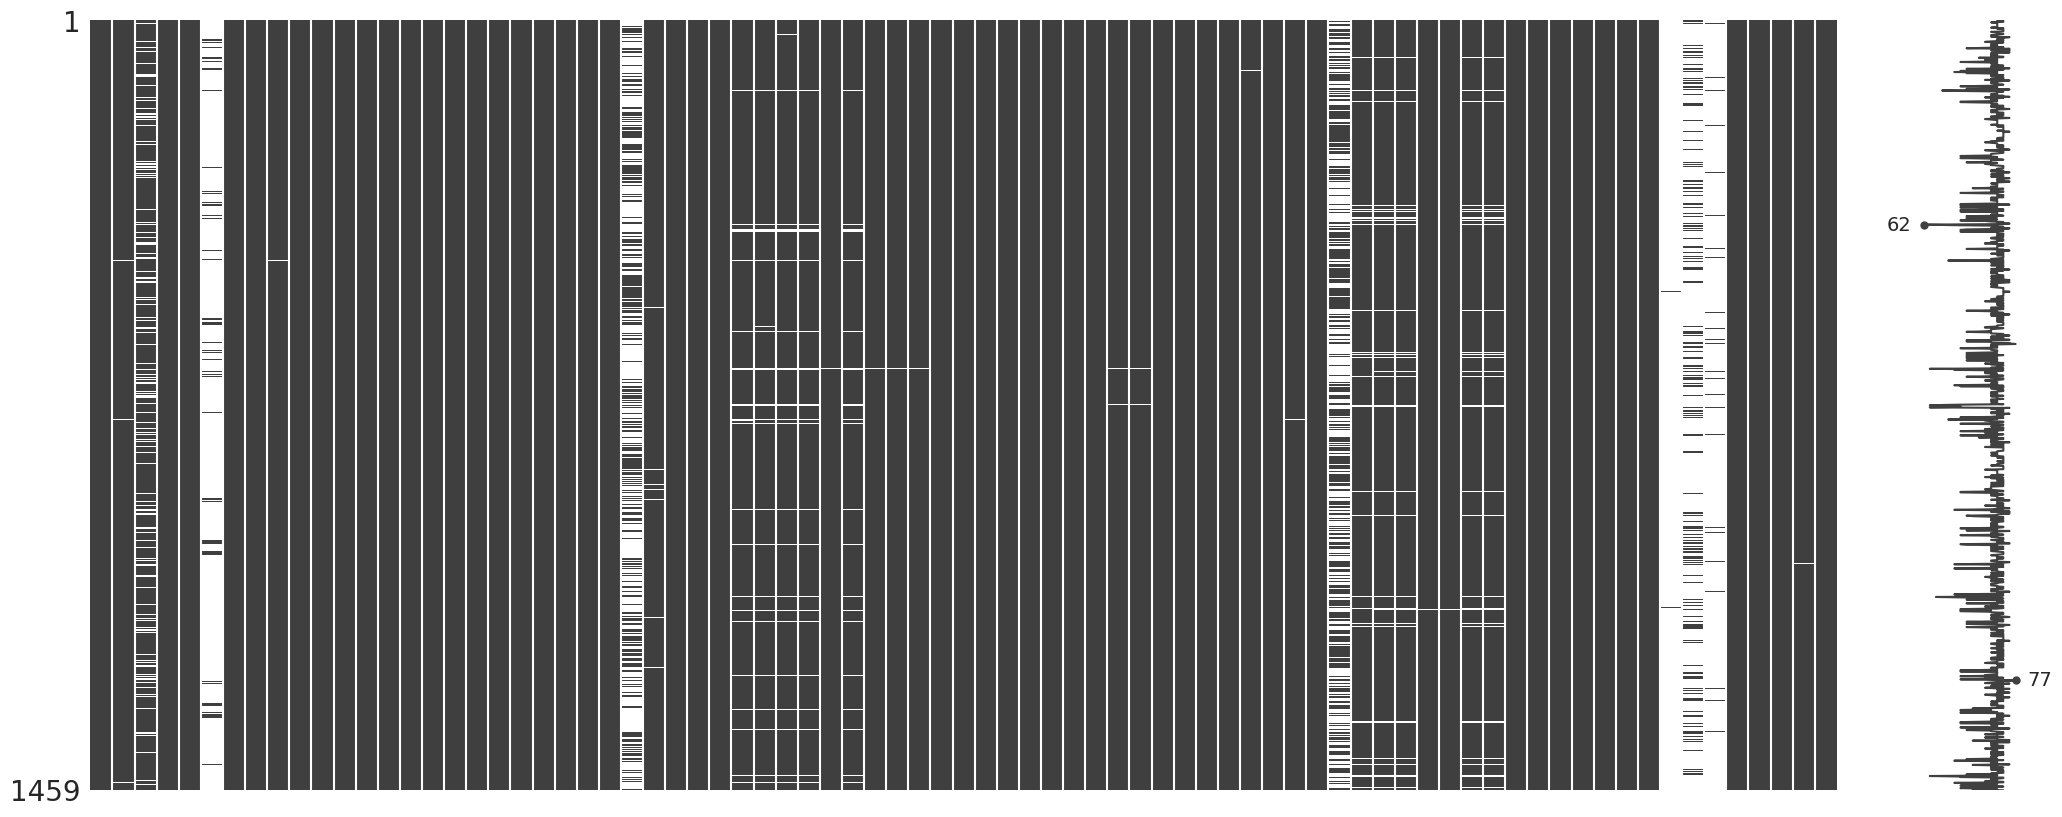

In [247]:
# Visualize missing values
msno.matrix(submission_data)

In [248]:
# Check the columns with missing values
print(submission_data.columns[submission_data.isna().sum() > 0])

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')


In [249]:
def proportion_miss_values(column):
    miss_value_sum = submission_data[column].isna().sum() 
    return pd.Series(miss_value_sum / submission_data.shape[0], index=[column])

/tmp/ipykernel_1290/39576046.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')


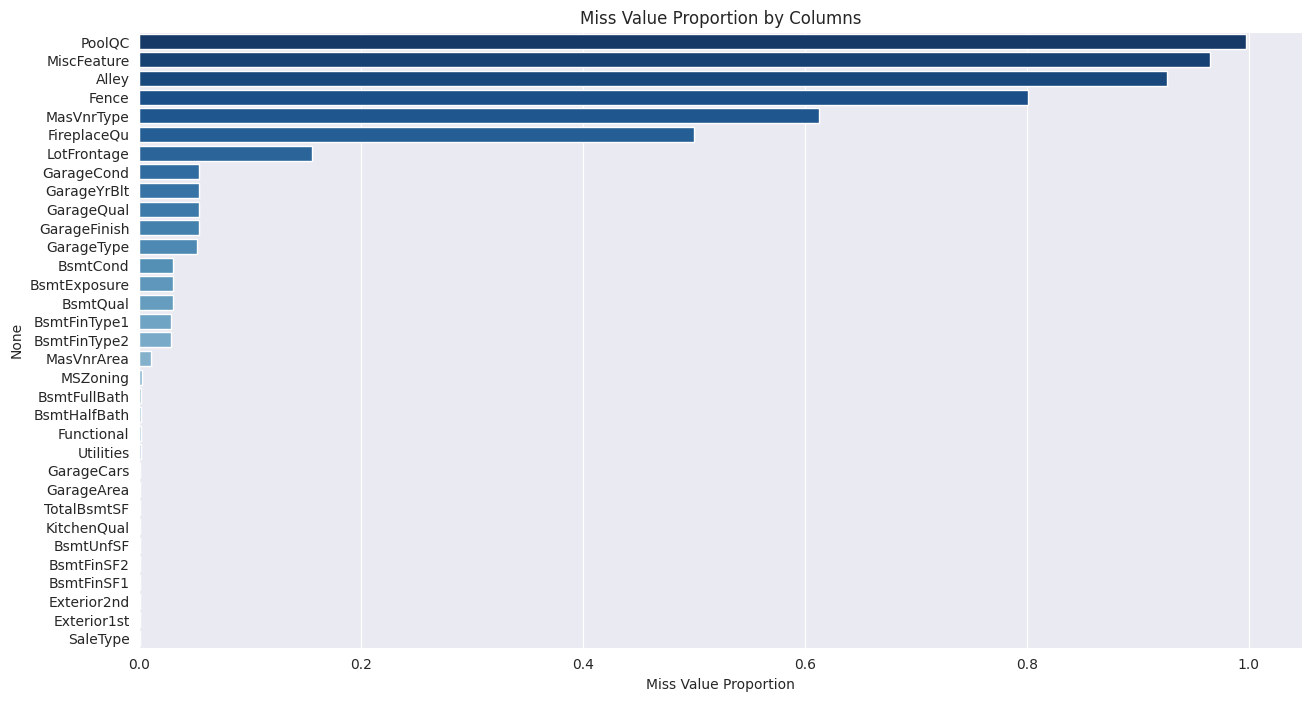

In [250]:
proportion_df = pd.DataFrame([])
missing_columns = submission_data.columns[submission_data.isna().sum() > 0]
for i, column in enumerate(missing_columns):
    new_proportion = proportion_miss_values(column)
    proportion_df = pd.concat([proportion_df, new_proportion], axis=0)     

proportion_df.columns = ['miss_value_proportion']
proportion_df = proportion_df.sort_values('miss_value_proportion', ascending=False)
fig = plt.figure(figsize=(15,8))
sns.barplot(data=proportion_df, y=proportion_df.index, x='miss_value_proportion', palette="Blues_r", orient='h')
plt.xlabel("Miss Value Proportion")
plt.title("Miss Value Proportion by Columns")
plt.show()

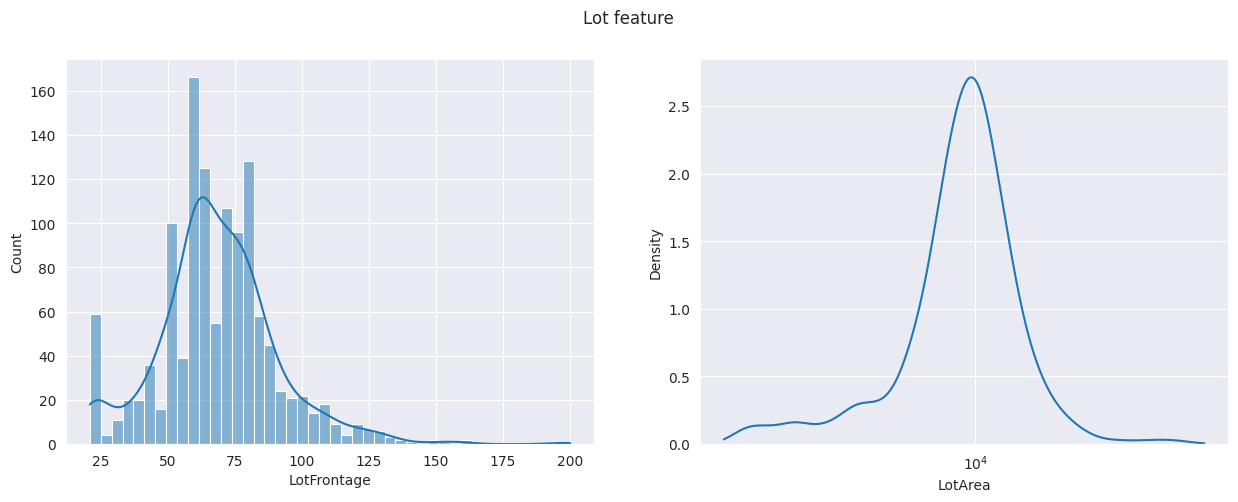

In [183]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=submission_data, x='LotFrontage', ax=axs[0], kde=True)
sns.kdeplot(submission_data['LotArea'], cut=1, log_scale=True, ax=axs[1])
plt.suptitle("Lot feature")
plt.show()

In [251]:
# Categorical columns where missing values were found
target_missing_columns = {
    "Alley": "No Alley",
    "LotFrontage": np.median(submission_data[~submission_data['LotFrontage'].isna()]['LotFrontage']),
    "MasVnrType": "None",
    "BsmtQual": "No basement",
    "BsmtCond": "No basement",
    "BsmtExposure": "No basement",
    "BsmtFinType1": "No basement",
    "BsmtFinType2": "No basement",
    "FireplaceQu": "No Fireplace",
    "GarageType": "No Garage",
    "GarageFinish": "No Garage",
    "GarageQual": "No Garage",
    "GarageCond": "No Garage",
    "PoolQC": "No Pool",
    "Fence": "No Fence",
    "MiscFeature": "None",
    "Electrical": "SBrkr"
}
# Dependent columns
missing_dependent_columns = {
    "MasVnrArea": ["MasVnrType", "None"],
    "GarageYrBlt": ["GarageType", "No Garage"]    
}

In [252]:
for column, fill_value in target_missing_columns.items():    
    submission_data[column] = submission_data[column].fillna(fill_value) 

for dependent_column, (column, value) in missing_dependent_columns.items():
    submission_data.loc[submission_data[column] == value, dependent_column] = 0 

<Axes: >

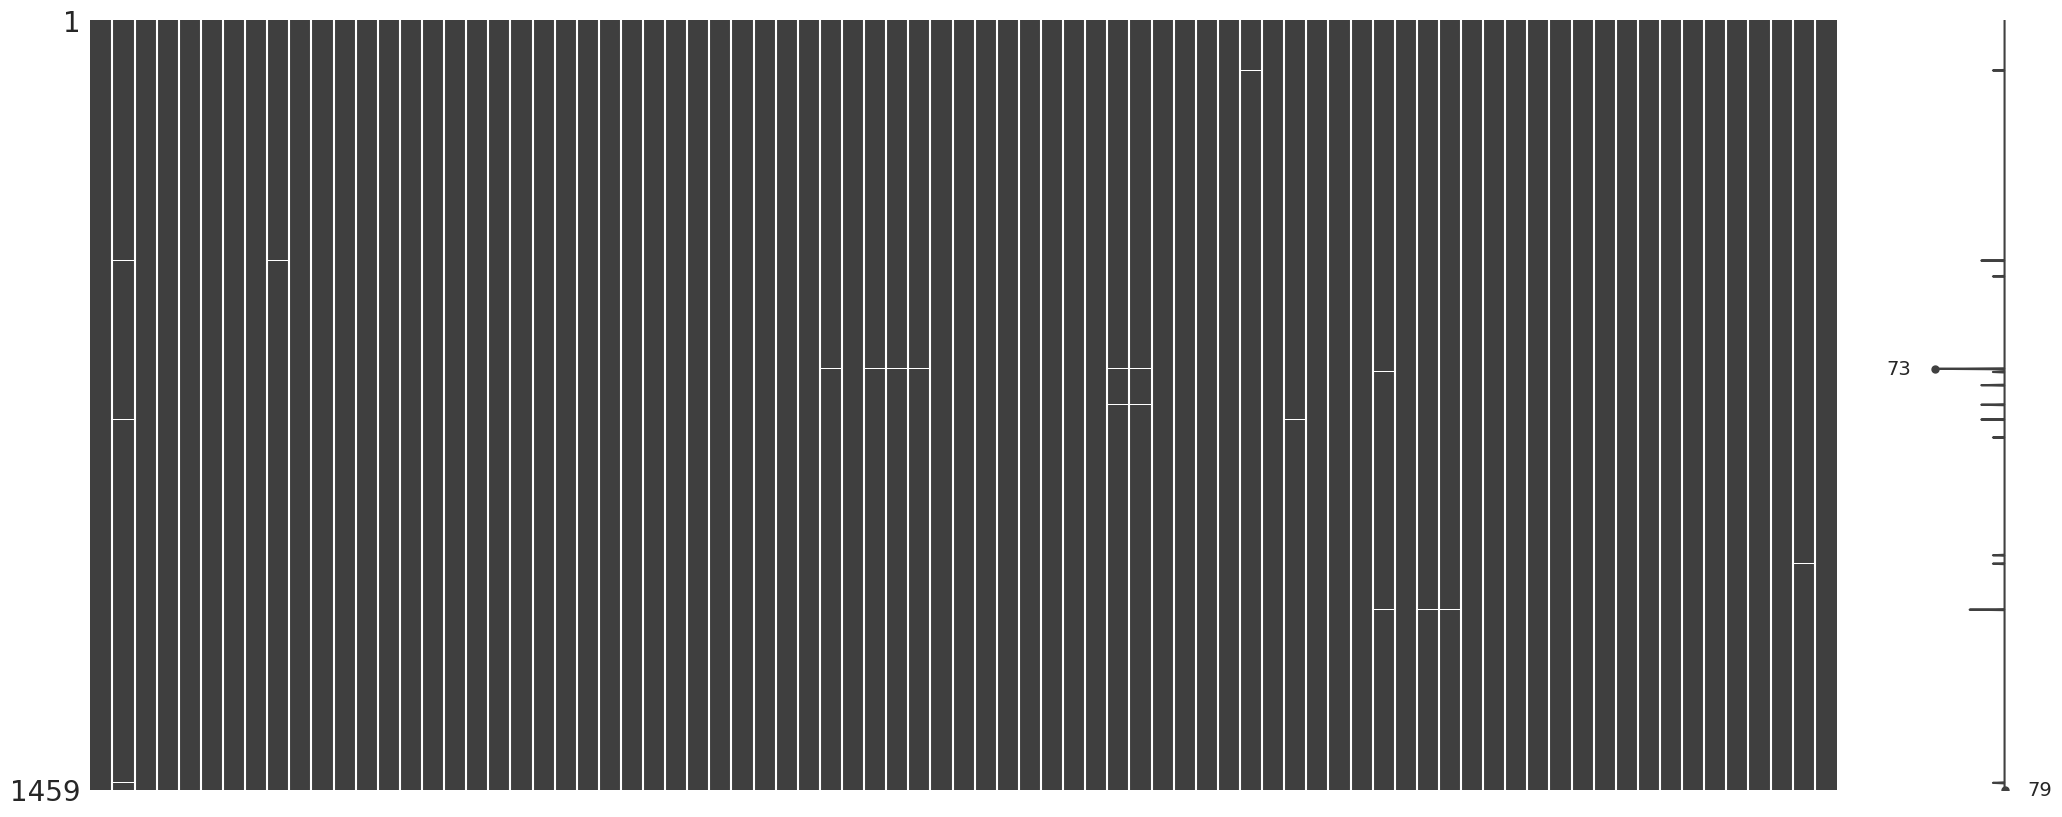

In [253]:
# Visualize missing values
msno.matrix(submission_data)

In [254]:
target_missing_columns = {
    "MSZoning": "RL",
    "Utilities": "AllPub",
    "Exterior1st": "VinylSd",
    "Exterior2nd": "VinylSd",    
    "Functional": "Typ",
    "SaleType": "WD",
    "KitchenQual": "TA",    
}

# Dependent columns
missing_dependent_columns = {
    "BsmtFinSF1": ["BsmtFinType1", "No basement"],
    "BsmtFinSF2": ["BsmtFinType2", "No basement"],
    "BsmtUnfSF": ["BsmtFinType1", "No basement"],
    "TotalBsmtSF": ["BsmtFinType1", "No basement"],
    "BsmtFullBath": ["BsmtFinType1", "No basement"],
    "BsmtHalfBath": ["BsmtFinType1", "No basement"],
    "GarageCars": ["GarageQual", "No Garage"],
    "GarageArea": ["GarageQual", "No Garage"] 
        
}

In [255]:
# Check the columns with missing values
print(submission_data.columns[submission_data.isna().sum() > 0])

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'SaleType'],
      dtype='object')


Let's analyze the columns related with the basement

In [188]:
submission_data.loc[submission_data['BsmtFinSF1'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement


In [189]:
submission_data.loc[submission_data['BsmtFinSF2'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement


In [190]:
submission_data.loc[submission_data['BsmtUnfSF'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement


In [191]:
submission_data.loc[submission_data['TotalBsmtSF'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement


In [192]:
submission_data.loc[submission_data['BsmtFullBath'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement
728,No basement,No basement


In [193]:
submission_data.loc[submission_data['BsmtHalfBath'].isna(), ['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
660,No basement,No basement
728,No basement,No basement


Let's analyze Kitchen feature

In [196]:
submission_data.loc[submission_data['KitchenQual'].isna(), ['KitchenAbvGr', 'OverallQual']]

,KitchenAbvGr,OverallQual
95,1,5


Let's analyze the Garage feature

In [229]:
submission_data.loc[submission_data['GarageYrBlt'].isna(), ['GarageCars', 'GarageArea']]

,GarageCars,GarageArea
666,1.0,360.0


In [228]:
submission_data.loc[submission_data['GarageCars'].isna(), ['GarageYrBlt', 'GarageArea', 'GarageType', "GarageFinish", 'GarageQual']]

,GarageYrBlt,GarageArea,GarageType,GarageFinish,GarageQual
1116,0.0,NaN,Detchd,No Garage,No Garage


In [256]:
submission_data.at[1116,'GarageYrBlt'] = 0.0
submission_data.at[1116,'GarageType'] = "No Garage"

In [257]:
submission_data.loc[submission_data['GarageYrBlt'].isna(), ['YearBuilt', 'YearRemodAdd',"YrSold"]]

,YearBuilt,YearRemodAdd,YrSold
666,1910,1983,2008


In [258]:
submission_data.at[666,'GarageYrBlt'] = 1910.0

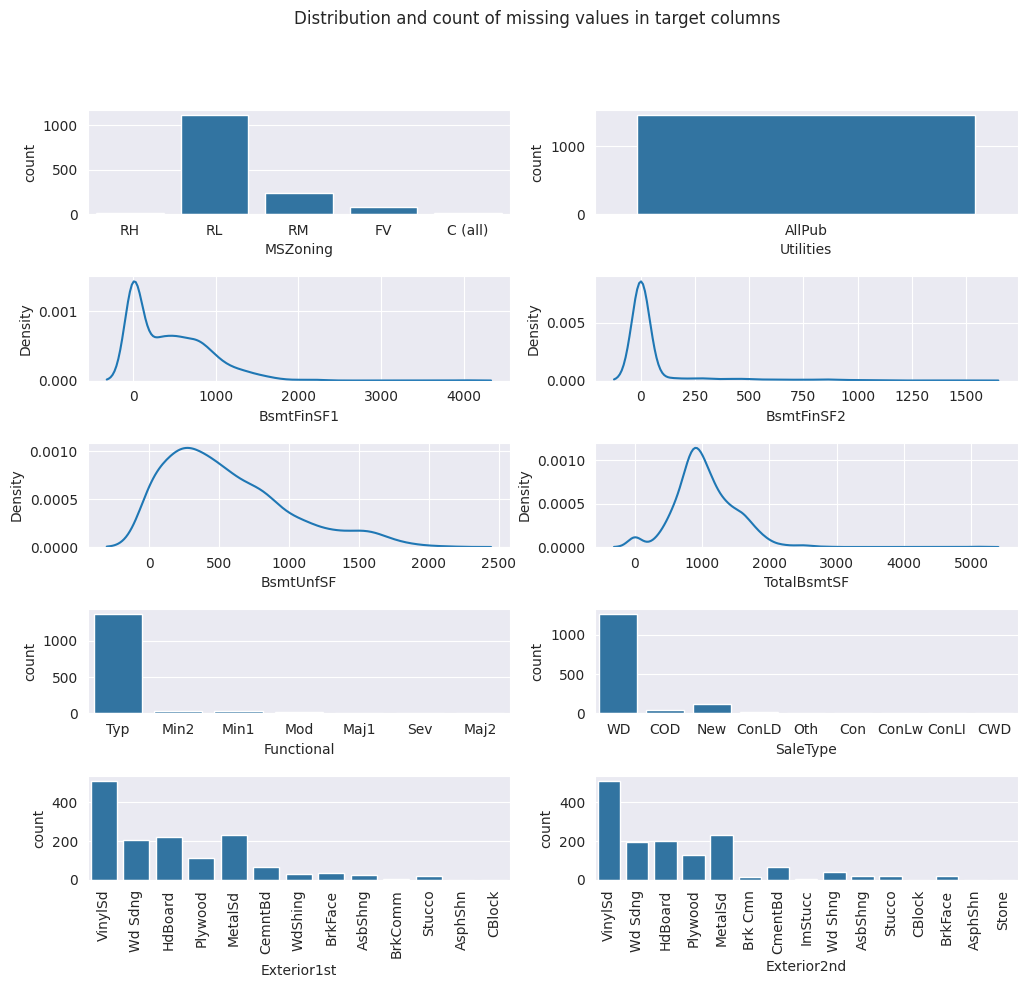

In [76]:
fig, axs = plt.subplots(5,2, figsize=(12, 10))
sns.countplot(data=submission_data, x='MSZoning', ax=axs[0,0])
sns.countplot(data=submission_data, x='Utilities', ax=axs[0,1])
sns.kdeplot(data=submission_data, x='BsmtFinSF1', ax=axs[1,0])
sns.kdeplot(data=submission_data, x='BsmtFinSF2', ax=axs[1,1])
sns.kdeplot(data=submission_data, x='BsmtUnfSF', ax=axs[2,0])
sns.kdeplot(data=submission_data, x='TotalBsmtSF', ax=axs[2,1])
sns.countplot(data=submission_data, x='Functional', ax=axs[3,0])
sns.countplot(data=submission_data, x='SaleType', ax=axs[3,1])
sns.countplot(data=submission_data, x='Exterior1st', ax=axs[4,0])
sns.countplot(data=submission_data, x='Exterior2nd', ax=axs[4,1])

for ax in axs[4]:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.suptitle("Distribution and count of missing values in target columns")
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

In [259]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    submission_data.loc[submission_data[column] == value, dependent_column] = 0 

for column, fill_value in target_missing_columns.items():    
    submission_data[column] = submission_data[column].fillna(fill_value) 

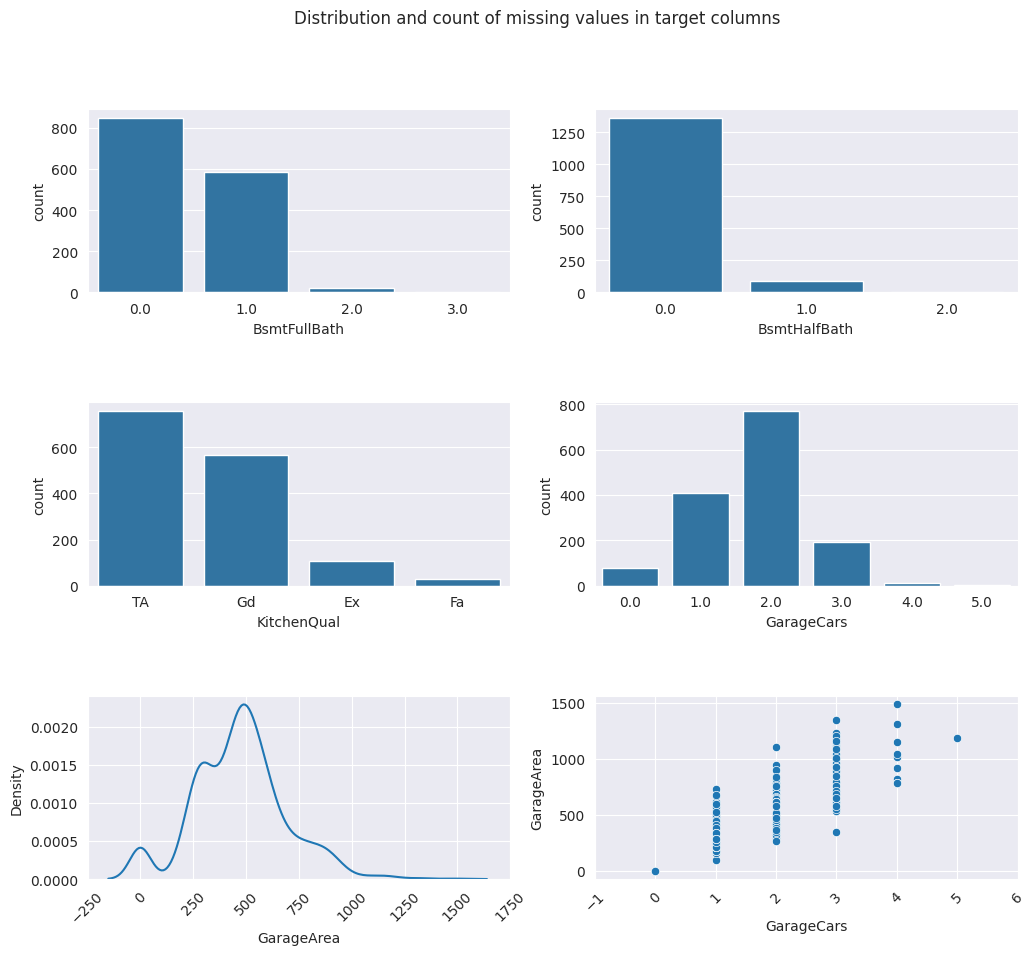

In [100]:
fig, axs = plt.subplots(3,2, figsize=(12, 10))
sns.countplot(data=submission_data, x='BsmtFullBath', ax=axs[0,0])
sns.countplot(data=submission_data, x='BsmtHalfBath', ax=axs[0,1])
sns.countplot(data=submission_data, x='KitchenQual', ax=axs[1,0])
sns.countplot(data=submission_data, x='GarageCars', ax=axs[1,1])
sns.kdeplot(data=submission_data, x='GarageArea', ax=axs[2,0])
sns.scatterplot(data=submission_data, x='GarageCars', y='GarageArea', ax=axs[2,1])

for ax in axs[2]:
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.suptitle("Distribution and count of missing values in target columns")
plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

In [157]:
missing_data = submission_data.loc[submission_data['KitchenQual'].isna(), ['KitchenAbvGr', 'OverallQual']]
missing_data.head()

,KitchenAbvGr,OverallQual
95,1,5


In [161]:
missing_data = submission_data.loc[submission_data['GarageYrBlt'].isna(), ['GarageCars', 'GarageArea']]
missing_data

,GarageCars,GarageArea
666,1.0,360.0
1116,NaN,NaN


In [165]:
missing_data = submission_data.loc[submission_data['GarageCars'].isna(), ['GarageYrBlt', 'GarageArea', 'GarageType', "GarageFinish", 'GarageQual']]
missing_data

,GarageYrBlt,GarageArea,GarageType,GarageFinish,GarageQual
1116,NaN,NaN,Detchd,No Garage,No Garage


In [166]:
submission_data.loc[submission_data['GarageType']=="Detchd", ['GarageYrBlt', 'GarageArea', 'GarageCars', "GarageFinish", 'GarageQual']]

,GarageYrBlt,GarageArea,GarageCars,GarageFinish,GarageQual
11,1971.0,264.0,1.0,Unf,TA
12,1997.0,320.0,1.0,Unf,TA
31,1920.0,429.0,1.0,Unf,TA
37,2004.0,480.0,2.0,RFn,TA
38,2004.0,480.0,2.0,RFn,TA
...,...,...,...,...,...
1426,1942.0,215.0,1.0,Unf,TA
1427,1950.0,506.0,2.0,Fin,TA
1429,1925.0,272.0,1.0,Unf,TA
1430,1957.0,384.0,1.0,Unf,TA


In [237]:
for dependent_column, (column, value) in missing_dependent_columns.items():
    submission_data.loc[submission_data[column] == value, dependent_column] = 0 
    
for column, fill_value in target_missing_columns.items():    
    submission_data[column] = submission_data[column].fillna(fill_value) 


Preprocessing submission data

In [260]:
# List of categorical columns to Label Encoder
target_le_columns = (
    "MSSubClass", "LotShape", "LandContour", "LandSlope", \
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", \
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", \
    "KitchenQual", "FireplaceQu", "GarageFinish", "GarageQual", \
    "GarageCond", "PavedDrive", "PoolQC", "Fence", "YrSold"    
)

In [261]:
from sklearn.preprocessing import LabelEncoder

for column in target_le_columns:
    # Encoder
    encoder = LabelEncoder()    
    submission_data[column] = encoder.fit_transform(submission_data[column].values)
submission_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,RH,80.0,11622,Pave,No Alley,3,3,AllPub,Inside,...,120,0,2,2,None,0,6,4,WD,Normal
1,0,RL,81.0,14267,Pave,No Alley,0,3,AllPub,Corner,...,0,0,2,4,Gar2,12500,6,4,WD,Normal
2,5,RL,74.0,13830,Pave,No Alley,0,3,AllPub,Inside,...,0,0,2,2,None,0,3,4,WD,Normal
3,5,RL,78.0,9978,Pave,No Alley,0,3,AllPub,Inside,...,0,0,2,4,None,0,6,4,WD,Normal
4,11,RL,43.0,5005,Pave,No Alley,0,1,AllPub,Inside,...,144,0,2,4,None,0,1,4,WD,Normal


In [262]:
numeric_feats = submission_data.dtypes[submission_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = submission_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
3SsnPorch,12.511336
LandSlope,4.963280
EnclosedPorch,4.664371
KitchenAbvGr,4.074860
BsmtFinSF2,4.038796
ScreenPorch,3.784349
BsmtHalfBath,3.779085


In [263]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lambda_value = 0.0
for feat in skewed_features:    
    submission_data[feat] = np.log1p(submission_data[feat])

There are 55 skewed numerical features to Box Cox transform


In [264]:
submission_data = pd.get_dummies(submission_data)
submission_data.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,4.394449,9.360741,1.386294,1.386294,0.0,1.791759,1.945910,7.581720,7.581720,...,False,False,False,True,False,False,False,False,True,False
1,0.000000,4.406719,9.565775,0.000000,1.386294,0.0,1.945910,1.945910,7.580189,7.580189,...,False,False,False,True,False,False,False,False,True,False
2,1.791759,4.317488,9.534668,0.000000,1.386294,0.0,1.791759,1.791759,7.599902,7.600402,...,False,False,False,True,False,False,False,False,True,False
3,1.791759,4.369448,9.208238,0.000000,1.386294,0.0,1.945910,1.945910,7.600402,7.600402,...,False,False,False,True,False,False,False,False,True,False
4,2.484907,3.784190,8.518392,0.000000,0.693147,0.0,2.197225,1.791759,7.597396,7.597396,...,False,False,False,True,False,False,False,False,True,False


In [266]:
predictions = pd.DataFrame([])

predictions = pd.concat([predictions, pd.Series(lasso.predict(rs.fit_transform(submission_data)))], axis=1)
predictions = pd.concat([predictions, pd.Series(ridge.predict(rs.fit_transform(submission_data)))], axis=1)
predictions = pd.concat([predictions, pd.Series(svr.predict(rs.fit_transform(submission_data)))], axis=1)
predictions = pd.concat([predictions, pd.Series(elastic_net.predict(rs.fit_transform(submission_data)))], axis=1)
predictions = pd.concat([predictions, pd.Series(xgboost.predict(submission_data))], axis=1)

predictions.columns = ["Lasso", "Ridge", "SVR", "ElasticNet", "XGBoost"]

ValueError: X has 213 features, but Lasso is expecting 227 features as input.